# MLPy — Sesión 4: Bucles de entrenamiento y evaluación (PyTorch)

**Objetivo:** aprender a entrenar y evaluar un modelo de manera **correcta y repetible**, distinguiendo claramente:

- **épocas**, **batches** e **iteraciones**
- **entrenamiento** vs **validación**
- **pérdida** (se optimiza) vs **métricas** (se reportan)

> Pregunta guía: ¿puedes explicar qué ocurre *exactamente* en una iteración de entrenamiento?


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

torch.manual_seed(0)


## 1) Dataset simple (clasificación 2D)

Usaremos dos nubes Gaussianas en 2D para enfocarnos en el **proceso** (no en el dataset).

La meta de esta sesión no es el mejor accuracy, sino:
- construir un **training loop** correcto
- separar el **validation loop**
- observar **curvas de entrenamiento** y **validación**


In [2]:
# Dataset sintético: dos clases separadas en 2D
N = 800
x0 = torch.randn(N//2, 2) + torch.tensor([-2.0, 0.0])
x1 = torch.randn(N//2, 2) + torch.tensor([ 2.0, 0.0])

X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(N//2), torch.ones(N//2)]).long()

# Mezclar el dataset
perm = torch.randperm(N)
X = X[perm]
y = y[perm]

# Split entrenamiento / validación
train_frac = 0.8
n_train = int(N * train_frac)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:], y[n_train:]

X_train.shape, X_val.shape


(torch.Size([640, 2]), torch.Size([160, 2]))

## 2) Épocas, batches e iteraciones

Recordatorio práctico:

- **Batch**: subconjunto de datos
- **Iteración**: forward + loss + backward + update sobre *un batch*
- **Época**: pasar por *todo* el dataset una vez

Relación clave:
- **1 batch = 1 iteración**
- **iteraciones por época = número de batches por época**


In [3]:
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=batch_size, shuffle=False)

iters_per_epoch = len(train_loader)
iters_per_epoch


20

## 3) Modelo, pérdida y optimizador

En esta sesión usamos `nn.Module` y `torch.optim` (a diferencia de la sesión 3).

**Importante:** la pérdida (loss) es el valor que optimizamos.  
La métrica (accuracy) la usamos para interpretar resultados.


In [4]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

model


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
)

## 4) Entrenamiento vs evaluación

- En **entrenamiento**: `model.train()` y se calculan gradientes.
- En **evaluación**: `model.eval()` y **no** calculamos gradientes (`torch.no_grad()`).

Separar estas dos fases reduce errores y hace el proceso **diagnosticable**.


In [5]:
def accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for xb, yb in loader:
        # 1) forward
        logits = model(xb)

        # 2) loss
        loss = criterion(logits, yb)

        # 3) backward
        optimizer.zero_grad()
        loss.backward()

        # 4) update
        optimizer.step()

        # métricas
        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 5) Entrenar y registrar curvas

Vamos a registrar por época:
- `train_loss`, `val_loss`
- `train_acc`, `val_acc`

La señal típica de sobreajuste es:
- `train_loss` baja
- `val_loss` sube (o deja de bajar)


In [6]:
# Entrenamiento principal
epochs = 40

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f} | train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")


Epoch 01 | train_loss=0.2530 val_loss=0.1363 | train_acc=0.947 val_acc=0.969
Epoch 10 | train_loss=0.0792 val_loss=0.0543 | train_acc=0.970 val_acc=0.988
Epoch 20 | train_loss=0.0761 val_loss=0.0514 | train_acc=0.973 val_acc=0.988
Epoch 30 | train_loss=0.0750 val_loss=0.0505 | train_acc=0.973 val_acc=0.988
Epoch 40 | train_loss=0.0740 val_loss=0.0511 | train_acc=0.973 val_acc=0.988


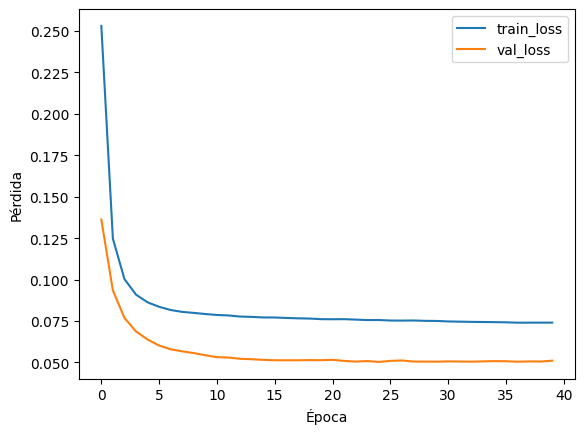

In [7]:
# Curvas de pérdida
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()


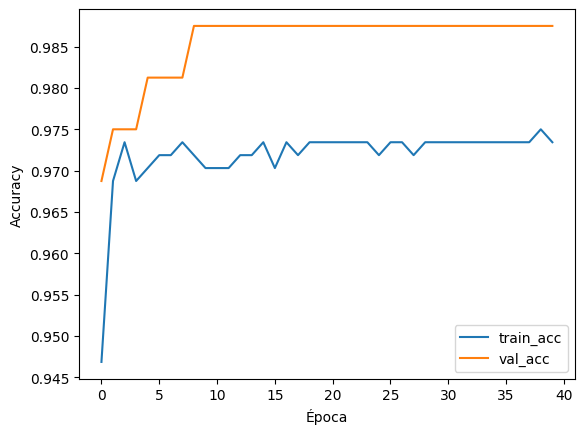

In [8]:
# Curvas de accuracy
plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 6) Experimento: efecto del batch size

**Idea:** el gradiente con batches es una aproximación.  
- Batch pequeño → gradiente más ruidoso → más variabilidad en la trayectoria.
- Batch grande → gradiente más estable → menos variabilidad.

Vamos a comparar dos tamaños de batch manteniendo todo lo demás constante.


In [9]:
def run_training(batch_size: int, epochs: int = 30, lr: float = 0.1):
    torch.manual_seed(0)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=batch_size, shuffle=False)

    model = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2)
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    tr_losses, va_losses = [], []
    for _ in range(epochs):
        tr_loss, _ = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, _ = eval_one_epoch(model, val_loader, criterion)
        tr_losses.append(tr_loss)
        va_losses.append(va_loss)

    return tr_losses, va_losses

small_tr, small_va = run_training(batch_size=8,  epochs=30, lr=0.1)
large_tr, large_va = run_training(batch_size=256, epochs=30, lr=0.1)

len(small_tr), len(large_tr)


(30, 30)

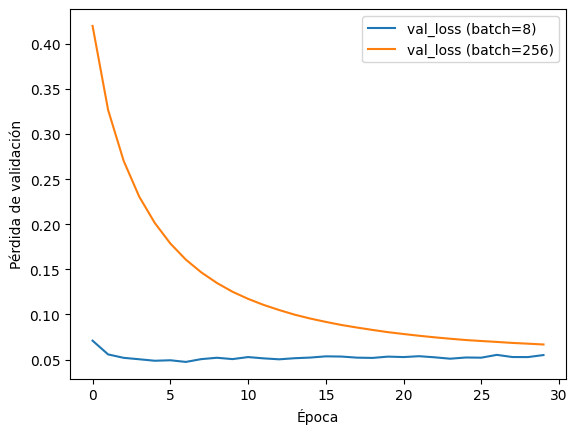

In [10]:
plt.figure()
plt.plot(small_va, label="val_loss (batch=8)")
plt.plot(large_va, label="val_loss (batch=256)")
plt.xlabel("Época")
plt.ylabel("Pérdida de validación")
plt.legend()
plt.show()


## 7) Experimento: sobreajuste intencional

Una forma simple de provocar sobreajuste:
- entrenar con **muy pocos datos**
- usar un modelo con **mucha capacidad**
- entrenar suficientes épocas

Buscamos el patrón típico:
- `train_loss` sigue bajando
- `val_loss` deja de bajar o empeora


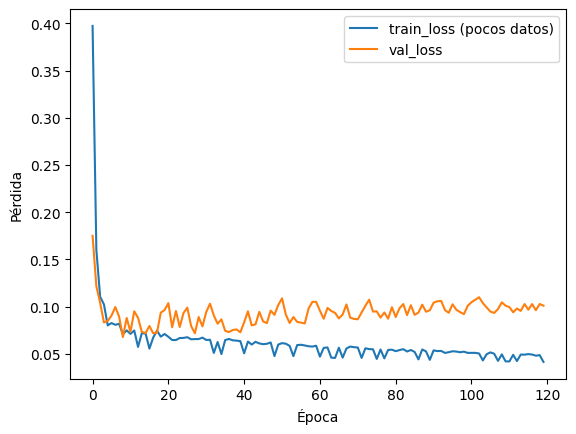

In [11]:
# Subconjunto pequeño para entrenar
torch.manual_seed(0)
n_small = 40  # muy pocos ejemplos
X_small, y_small = X_train[:n_small], y_train[:n_small]

small_train_loader = DataLoader(TensorDataset(X_small, y_small), batch_size=8, shuffle=True)
small_val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=64, shuffle=False)

# Modelo más grande (más capacidad)
big_model = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

big_opt = torch.optim.SGD(big_model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

epochs = 120
tr_loss_hist, va_loss_hist = [], []
tr_acc_hist,  va_acc_hist  = [], []

for epoch in range(epochs):
    tr_loss, tr_acc = train_one_epoch(big_model, small_train_loader, big_opt, criterion)
    va_loss, va_acc = eval_one_epoch(big_model, small_val_loader, criterion)

    tr_loss_hist.append(tr_loss)
    va_loss_hist.append(va_loss)
    tr_acc_hist.append(tr_acc)
    va_acc_hist.append(va_acc)

plt.figure()
plt.plot(tr_loss_hist, label="train_loss (pocos datos)")
plt.plot(va_loss_hist, label="val_loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()


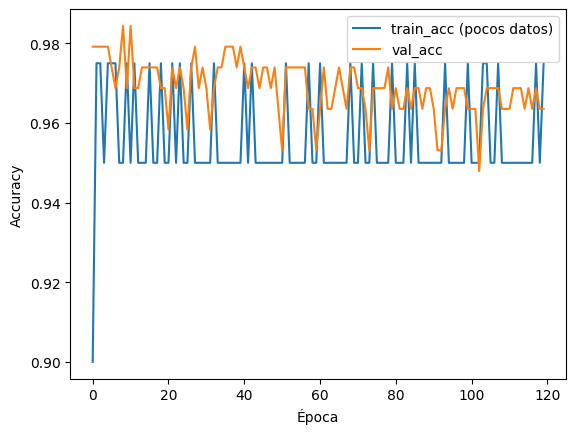

In [12]:
plt.figure()
plt.plot(tr_acc_hist, label="train_acc (pocos datos)")
plt.plot(va_acc_hist, label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 8) Preguntas de cierre (para discusión)

1. ¿Qué diferencia conceptual hay entre **pérdida** y **accuracy**?

2. ¿Por qué la validación es un **diagnóstico** y no una “meta” de entrenamiento?

3. ¿Qué señales te permiten distinguir **sobreajuste** vs **subajuste** usando curvas?

4. En tus resultados, ¿qué cambió al variar el **batch size**?

5. ¿Qué error te parece más peligroso: olvidar `optimizer.zero_grad()` o evaluar sin `model.eval()`?

